In [92]:
import glob
import os
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from PIL import Image
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [93]:
# Uyarıları yok say
import warnings
warnings.filterwarnings("ignore")

In [94]:
#Veri setini içeri aktar
imgs = glob.glob("./faces_four/*.pgm")

In [95]:
# Resim boyutları
width = 128
height = 120
X = []
Y = []

# Tüm resim dosyalarını oku ve işleme al
for img in imgs:
    filename = os.path.basename(img)
    user_id, pose, expression, eyes, scale = filename[:-4].split("_")
    
    # Resmi yükle ve gri tonlamalıya çevir
    im = Image.open(img).convert('L')  

    # Resmi yeniden boyutlandır ve normalleştir
    im = im.resize((width,height))
    im = np.array(im) / 255.0  
    X.append(im)
    Y.append((user_id, pose, expression, eyes, scale))  

# Resimleri pad etmek ve array'e dönüştürmek
X = np.array([np.pad(img, ((0, height - img.shape[0]), (0, width - img.shape[1])), mode='constant') for img in X])
X = X.reshape(X.shape[0],height,width, 1)
Y = np.array(Y)  # Convert Y to a numpy array


# Veri şekillerini kontrol et
print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)
print("First 5 labels in Y:", Y[:5])

Shape of X: (624, 120, 128, 1)
Shape of Y: (624, 5)
First 5 labels in Y: [['an2i' 'left' 'angry' 'open' '4']
 ['an2i' 'left' 'angry' 'sunglasses' '4']
 ['an2i' 'left' 'happy' 'open' '4']
 ['an2i' 'left' 'happy' 'sunglasses' '4']
 ['an2i' 'left' 'neutral' 'open' '4']]


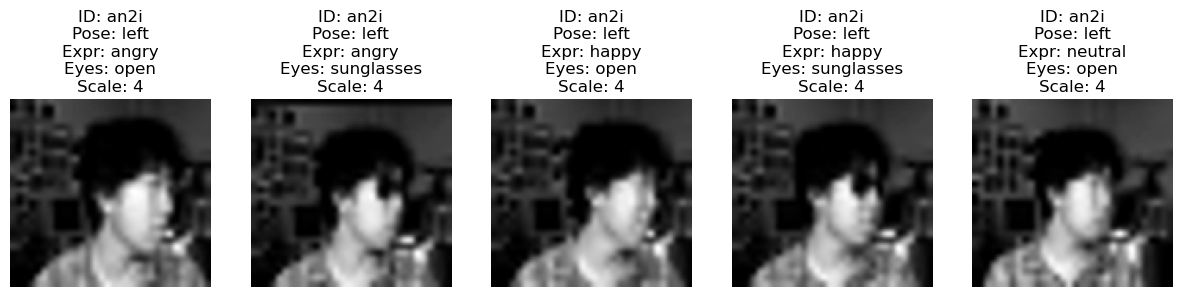

In [96]:
# Örnek resimleri ve etiketleri göster
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i in range(5):
    axes[i].imshow(X[i].reshape(target_height, target_width), cmap='gray')
    axes[i].set_title(f"ID: {Y[i][0]}\nPose: {Y[i][1]}\nExpr: {Y[i][2]}\nEyes: {Y[i][3]}\nScale: {Y[i][4]}")
    axes[i].axis('off')
plt.show()


In [100]:
# One-hot encoding fonksiyonu
def onehot_labels(values, column_index):
    label_encoder = LabelEncoder()
    onehot_encoder = OneHotEncoder(sparse=False)
    # Belirtilen sütunu seç ve 1D dizi yap
    column_values = [item[0] for item in values]
    integer_encoded = label_encoder.fit_transform(column_values)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    return onehot_encoded

# Kullanıcı kimliği sütunu (0. sütun) ile one-hot encoding yap
Y_encoded = onehot_labels(Y, 0)


# One-hot encoded Y dizisinin şekli
print("Shape of one-hot encoded Y:", Y_encoded.shape)


Shape of one-hot encoded Y: (624, 20)


In [101]:
# Veriyi eğitim ve test setlerine ayır
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.25, random_state=2)
train_Y_encoded = onehot_labels(train_Y,0)
print("Shape of one-hot encoded Y:", train_Y_encoded.shape)


# Bölme sonrası veri şekillerini kontrol et
print("Shape of train_X:", train_X.shape)
print("Shape of test_X:", test_X.shape)
print("Shape of train_Y:", train_Y.shape)
print("Shape of test_Y:", test_Y.shape)

Shape of one-hot encoded Y: (468, 20)
Shape of train_X: (468, 120, 128, 1)
Shape of test_X: (156, 120, 128, 1)
Shape of train_Y: (468, 5)
Shape of test_Y: (156, 5)


In [106]:

# CNN modelini oluştur
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(width, height, 1)))
model.add(Conv2D(64, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(20, activation="softmax")) 

# Modeli derle
model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])

# Modeli eğit
model.fit(train_X, train_Y_encoded, epochs=15, batch_size=32, validation_split=0.2)

# Eğitim doğruluğunu değerlendirme
score_train = model.evaluate(train_X, train_Y_encoded)
print("Eğitim doğruluğu: %", score_train[1] * 100)

# Test doğruluğunu değerlendirme
test_Y_encoded = onehot_labels(test_Y,0)
score_test = model.evaluate(test_X, test_Y_encoded)
print("Test doğruluğu: %", score_test[1] * 100)



Epoch 1/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 531ms/step - accuracy: 0.1277 - loss: 3.4531 - val_accuracy: 0.5319 - val_loss: 2.3310
Epoch 2/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 422ms/step - accuracy: 0.5056 - loss: 1.8958 - val_accuracy: 0.9787 - val_loss: 0.4528
Epoch 3/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 425ms/step - accuracy: 0.8340 - loss: 0.5918 - val_accuracy: 0.9255 - val_loss: 0.1578
Epoch 4/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 428ms/step - accuracy: 0.8711 - loss: 0.3465 - val_accuracy: 0.9894 - val_loss: 0.0377
Epoch 5/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 421ms/step - accuracy: 0.9716 - loss: 0.1500 - val_accuracy: 0.9894 - val_loss: 0.0300
Epoch 6/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 434ms/step - accuracy: 0.9659 - loss: 0.1155 - val_accuracy: 1.0000 - val_loss: 0.0115
Epoch 7/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 431ms/step - accuracy: 0.9664 - loss: 0.1105 - val_accuracy: 1.0000 - val_loss: 0.0093
Epoch 8/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 432ms/step - accuracy: 0.9571 - loss: 0.1232 - val_accuracy: 0.

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step

Sınıflandırma Raporu:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      0.71      0.83         7
           2       1.00      1.00      1.00         9
           3       0.75      1.00      0.86         6
           4       1.00      1.00      1.00        12
           5       1.00      1.00      1.00         8
           6       1.00      1.00      1.00         8
           7       1.00      1.00      1.00        11
           8       1.00      1.00      1.00         8
           9       1.00      1.00      1.00         9
          10       1.00      1.00      1.00         8
          11       1.00      1.00      1.00        11
          12       1.00      1.00      1.00         6
          13       1.00      1.00      1.00         6
          14       1.00      1.00      1.00         9
          15       1.00      1.00      1.00         8
          16       

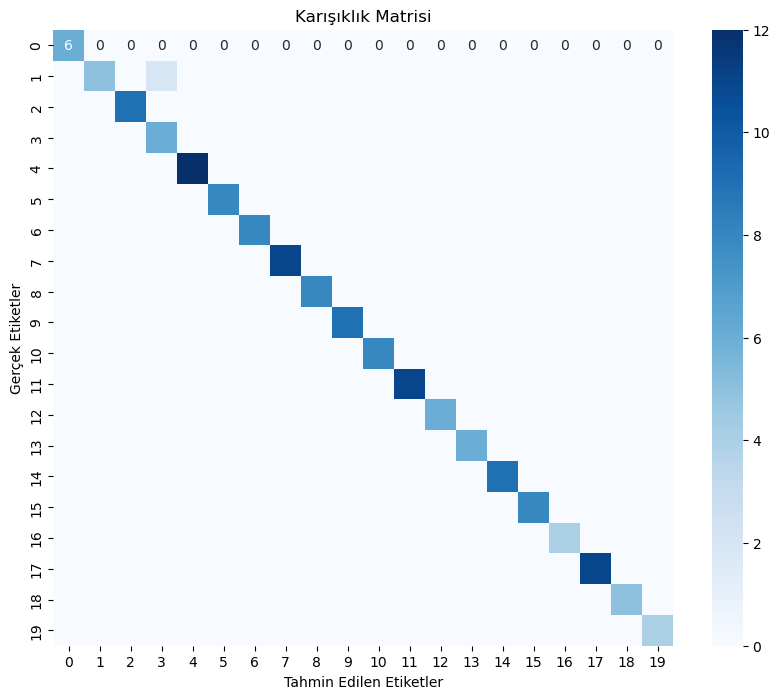

In [108]:
# Tahminleri al
pred_Y = model.predict(test_X)
pred_Y_classes = np.argmax(pred_Y, axis=1)
true_Y_classes = np.argmax(test_Y_encoded, axis=1)

# Sınıflandırma raporunu yazdır
class_report = classification_report(true_Y_classes, pred_Y_classes)
print("\nSınıflandırma Raporu:\n", class_report)

# Karışıklık matrisini göster
conf_matrix = confusion_matrix(true_Y_classes, pred_Y_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Tahmin Edilen Etiketler")
plt.ylabel("Gerçek Etiketler")
plt.title("Karışıklık Matrisi")
plt.show()